In [ ]:
!pip install --quiet kaggle torch torchvision matplotlib scikit-learn joblib

import os, zipfile, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models, datasets

from sklearn.metrics import classification_report, confusion_matrix
import joblib

print("✅ Libraries installed & imported")

✅ Libraries installed & imported


In [ ]:
# 👇 Upload your kaggle.json (from your Kaggle account settings)
from google.colab import files
files.upload()  # Choose kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d rajumavinmar/finger-print-based-blood-group-dataset
!unzip -q finger-print-based-blood-group-dataset.zip -d dataset

print("✅ Dataset downloaded and extracted")

# Inspect structure
!ls dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/rajumavinmar/finger-print-based-blood-group-dataset
License(s): unknown
  0% 0.00/58.1M [00:00<?, ?B/s]
100% 58.1M/58.1M [00:00<00:00, 1.76GB/s]
✅ Dataset downloaded and extracted
dataset_blood_group


In [ ]:
import os, shutil, random

# Automatically detect the correct root containing class folders
possible_dirs = [os.path.join("dataset", d) for d in os.listdir("dataset")]
data_dir = None
for d in possible_dirs:
    if os.path.isdir(d) and len(os.listdir(d)) > 0:
        # Check if this folder directly contains class folders (like A+, B+, etc.)
        subdirs = [os.path.join(d, sd) for sd in os.listdir(d) if os.path.isdir(os.path.join(d, sd))]
        if len(subdirs) > 0 and all(os.path.isdir(s) for s in subdirs):
            data_dir = d
            break

if data_dir is None:
    raise RuntimeError("❌ Could not find dataset folder with class subdirectories. Check dataset/ structure.")

print(f"✅ Using data directory: {data_dir}")

# Define train/val target dirs
train_dir = "data/train"
val_dir = "data/val"

# Recreate split folders
if os.path.exists("data"):
    shutil.rmtree("data")

os.makedirs(train_dir)
os.makedirs(val_dir)

# Split 80/20 into train/val
for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if os.path.isdir(cls_path):
        images = []
        for root, _, files in os.walk(cls_path):
            for f in files:
                if f.lower().endswith((".jpg", ".jpeg", ".png")):
                    images.append(os.path.join(root, f))
        random.shuffle(images)
        split = int(0.8 * len(images))
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        for img in images[:split]:
            shutil.copy(img, os.path.join(train_dir, cls, os.path.basename(img)))
        for img in images[split:]:
            shutil.copy(img, os.path.join(val_dir, cls, os.path.basename(img)))

print("✅ Data split complete")


✅ Using data directory: dataset/dataset_blood_group
✅ Data split complete


In [ ]:
import os, shutil, random

source_root = "dataset/dataset_blood_group"
train_dir = "data/train"
val_dir = "data/val"

if os.path.exists("data"):
    shutil.rmtree("data")

os.makedirs(train_dir)
os.makedirs(val_dir)

valid_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

# Walk recursively and find all images
class_to_images = {}
for class_name in os.listdir(source_root):
    class_path = os.path.join(source_root, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = []
    for root, _, files in os.walk(class_path):
        for f in files:
            if f.lower().endswith(valid_exts):
                image_files.append(os.path.join(root, f))

    if len(image_files) == 0:
        print(f"⚠️ No images found for class {class_name} (checked recursively)")
        continue

    class_to_images[class_name] = image_files

# Split and copy
for cls, images in class_to_images.items():
    random.shuffle(images)
    split = int(0.8 * len(images))
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    for img in images[:split]:
        shutil.copy(img, os.path.join(train_dir, cls, os.path.basename(img)))
    for img in images[split:]:
        shutil.copy(img, os.path.join(val_dir, cls, os.path.basename(img)))

print(f"✅ Split complete — {len(class_to_images)} classes processed.")
for cls, imgs in class_to_images.items():
    print(f"  {cls}: {len(imgs)} images found")


✅ Split complete — 8 classes processed.
  AB+: 708 images found
  O-: 712 images found
  B-: 741 images found
  A+: 565 images found
  B+: 652 images found
  AB-: 761 images found
  A-: 1009 images found
  O+: 852 images found


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
val_data = datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)

class_names = train_data.classes
print("Classes:", class_names)

Classes: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']


In [ ]:
# 5️⃣  MODEL: RESNET-50
# ===============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("✅ Model ready on", device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


✅ Model ready on cuda


In [ ]:
EPOCHS = 20
best_acc = 0.0

for epoch in range(EPOCHS):
    model.train()
    running_loss, running_corrects = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.double() / len(train_data)

    # Validation
    model.eval()
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
    val_acc = val_corrects.double() / len(val_data)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "model_resnet50.pth")

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}")

print("✅ Training complete. Best Val Acc:", best_acc)


Epoch 1/20 | Train Acc: 0.5196 | Val Acc: 0.6977
Epoch 2/20 | Train Acc: 0.8274 | Val Acc: 0.8414
Epoch 3/20 | Train Acc: 0.8807 | Val Acc: 0.8804
Epoch 4/20 | Train Acc: 0.9068 | Val Acc: 0.8796
Epoch 5/20 | Train Acc: 0.9299 | Val Acc: 0.8771
Epoch 6/20 | Train Acc: 0.9485 | Val Acc: 0.8879
Epoch 7/20 | Train Acc: 0.9552 | Val Acc: 0.8679
Epoch 8/20 | Train Acc: 0.9658 | Val Acc: 0.8746
Epoch 9/20 | Train Acc: 0.9698 | Val Acc: 0.8829
Epoch 10/20 | Train Acc: 0.9814 | Val Acc: 0.8671
Epoch 11/20 | Train Acc: 0.9791 | Val Acc: 0.8771
Epoch 12/20 | Train Acc: 0.9877 | Val Acc: 0.8870
Epoch 13/20 | Train Acc: 0.9817 | Val Acc: 0.8671
Epoch 14/20 | Train Acc: 0.9837 | Val Acc: 0.8895
Epoch 15/20 | Train Acc: 0.9879 | Val Acc: 0.8870
Epoch 16/20 | Train Acc: 0.9889 | Val Acc: 0.8796
Epoch 17/20 | Train Acc: 0.9879 | Val Acc: 0.8837
Epoch 18/20 | Train Acc: 0.9856 | Val Acc: 0.8480
Epoch 19/20 | Train Acc: 0.9915 | Val Acc: 0.8746
Epoch 20/20 | Train Acc: 0.9873 | Val Acc: 0.8555
✅ Trainin

              precision    recall  f1-score   support

          A+       0.95      0.88      0.92       113
          A-       0.77      0.91      0.83       202
         AB+       0.99      0.72      0.83       142
         AB-       0.87      0.85      0.86       153
          B+       0.86      0.78      0.82       131
          B-       0.84      0.94      0.89       149
          O+       0.86      0.88      0.87       171
          O-       0.83      0.85      0.84       143

    accuracy                           0.86      1204
   macro avg       0.87      0.85      0.86      1204
weighted avg       0.86      0.86      0.86      1204



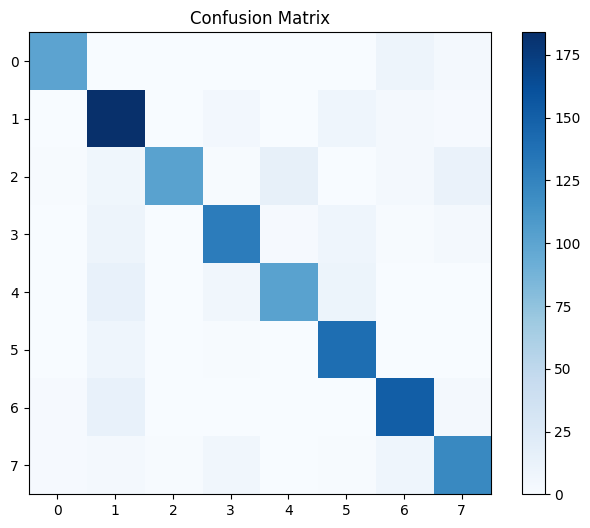

In [ ]:
# 7️⃣  EVALUATION
# ===============================================================

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

In [ ]:
# 8️⃣  SAVE METADATA
# ===============================================================

metadata = {
    "class_names": class_names,
    "image_size": (224, 224),
    "model_type": "resnet50"
}
joblib.dump(metadata, "metadata.pkl")
print("✅ Saved model_resnet50.pth and metadata.pkl")

✅ Saved model_resnet50.pth and metadata.pkl
